In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession, functions as F, Window
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from pyspark.sql import DataFrame
from functools import reduce
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## Using parquet data to do research

In [4]:
import pandas as pd
import duckdb
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MF810_Final_Project") \
    .master("local[*]") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()


path = "/Users/lucasking/Desktop/datasets/merged_cleaned.parquet"

# Covnert Parquet into DF
df = spark.read.parquet(path)
df = df.filter(F.col("ticker") != "merged_raw")


25/04/29 23:26:41 WARN Utils: Your hostname, Chuns-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.183 instead (on interface en0)
25/04/29 23:26:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/29 23:26:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/29 23:26:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
# test by AAPL
con = duckdb.connect()
df_aapl = (
    con
    .execute(f"""
        SELECT *
        FROM read_parquet('{path}')
        WHERE ticker = 'AAPL'
        LIMIT 5;
    """)
    .df()
)
print("=== DuckDB Query for AAPL ===")
print(df_aapl.head())

=== DuckDB Query for AAPL ===
   volume      vwap    open   close    high     low      timestamp  \
0  3056.0  164.0985  164.47  164.00  164.47  163.90  1680508800000   
1  1258.0  163.9985  164.00  164.00  164.00  164.00  1680508860000   
2   585.0  164.1085  164.09  164.09  164.09  164.09  1680508920000   
3   698.0  164.0203  164.02  164.00  164.03  164.00  1680508980000   
4  1888.0  164.0001  164.00  164.00  164.00  164.00  1680509040000   

   transactions             datetime ticker  
0           101  2023-04-03 08:00:00   AAPL  
1            42  2023-04-03 08:01:00   AAPL  
2            27  2023-04-03 08:02:00   AAPL  
3            20  2023-04-03 08:03:00   AAPL  
4             9  2023-04-03 08:04:00   AAPL  


### Convert datetime

In [6]:
df = df.withColumn("datetime", 
       F.to_timestamp("datetime", "yyyy-MM-dd HH:mm:ss")  
)
df.printSchema()  #check timestamp 


df2 = (df
    .withColumn("date" , F.to_date("datetime"))
    .withColumn("hour" , F.hour   ("datetime"))
)

# count trades in th day
(df2
 .groupBy("ticker", "date")
 .agg(F.count("*").alias("cnt"))
 .orderBy("ticker", "date")
 .show(10, truncate=False)
)

root
 |-- volume: double (nullable = true)
 |-- vwap: double (nullable = true)
 |-- open: double (nullable = true)
 |-- close: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- transactions: long (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- ticker: string (nullable = true)



+------+----------+---+
|ticker|date      |cnt|
+------+----------+---+
|A     |2023-04-03|392|
|A     |2023-04-04|383|
|A     |2023-04-05|388|
|A     |2023-04-06|371|
|A     |2023-04-10|351|
|A     |2023-04-11|382|
|A     |2023-04-12|374|
|A     |2023-04-13|371|
|A     |2023-04-14|355|
|A     |2023-04-17|375|
+------+----------+---+
only showing top 10 rows



In [7]:
df2 = (df
       .withColumn("date",  F.to_date  ("datetime"))   
       .withColumn("hour",  F.hour     ("datetime"))   
       .withColumn("minute",F.minute   ("datetime"))   
       .withColumn("ts_trunc", F.date_trunc("day", "datetime"))  
      )

df2.printSchema()
df2.show(5, truncate=False)

root
 |-- volume: double (nullable = true)
 |-- vwap: double (nullable = true)
 |-- open: double (nullable = true)
 |-- close: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- transactions: long (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- ticker: string (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- ts_trunc: timestamp (nullable = true)

+-------+--------+-------+--------+-------+------+-------------+------------+-------------------+------+----------+----+------+-------------------+
|volume |vwap    |open   |close   |high   |low   |timestamp    |transactions|datetime           |ticker|date      |hour|minute|ts_trunc           |
+-------+--------+-------+--------+-------+------+-------------+------------+-------------------+------+----------+----+------+-------------------+
|17632.0|137.0174

In [8]:
# Pick OCHL, vol, group by ticker,  date
df_daily = (
    df
    .withColumn("dt", F.to_date("datetime"))      
    .groupBy("ticker", "dt")                       
    .agg(
        F.first("open").alias("open"),           
        F.max  ("high").alias("high"),     
        F.min  ("low") .alias("low"),           
        F.last ("close").alias("close"),          
        F.sum  ("volume").alias("vol")        
    )
)

# top10 vol  tickers
top10 = (
    df_daily
    .groupBy("ticker")
    .agg(F.sum("vol").alias("total_vol"))
    .orderBy(F.desc("total_vol"))
    .limit(10)                
    .select("ticker")
    .rdd.flatMap(lambda r: r)
    .collect()
)
print("Top10 tickers:", top10)

# put back  to  pandas
df10 = (
    df_daily
    .filter(F.col("ticker").isin(top10))
    .orderBy("ticker", "dt")
    .toPandas()
)

#plot by Plotly Express 
fig = px.line(
    df10,
    x="dt", y="close",
    color="ticker",
    facet_col="ticker", facet_col_wrap=3,
    title="Top10 Volume Stocks Daily Close Price",
    labels={"dt": "Date", "close": "Close Price"}
)
fig.update_layout(height=600, width=900)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()

Top10 tickers: ['NVDA', 'TSLA', 'PLTR', 'F', 'AMD', 'INTC', 'AAPL', 'AMZN', 'BAC', 'T']


In [9]:
df_raw = (
    spark.read.parquet(path)
         .withColumn("dt", F.to_date("datetime"))
)

df_recent = df_raw.filter(F.col("dt") >= "2024-03-01").filter(F.col("ticker") != "merged_raw")


df_daily_recent = (
    df_recent
    .groupBy("ticker", "dt")
    .agg(F.sum("volume").alias("vol"))
)


top10_recent = (
    df_daily_recent
    .groupBy("ticker")
    .agg(F.sum("vol").alias("total_vol"))
    .orderBy(F.desc("total_vol"))
    .limit(10)
    .select("ticker")
    .rdd.flatMap(lambda r: r).collect())

print("RECENTLY 1 year highest Vol. 10:", top10_recent)

RECENTLY 1 year highest Vol. 10: ['NVDA', 'TSLA', 'PLTR', 'INTC', 'F', 'AAPL', 'AMD', 'AMZN', 'NU', 'PFE']


In [10]:
df10 = df10.sort_values(["ticker", "dt"])

import plotly.express as px

fig = px.line(
    df10,
    x="dt", y="close",
    line_group="ticker",      
    facet_col="ticker", 
    facet_col_wrap=5,
    hover_name="ticker",
    labels={"dt":"Date", "close":"Close"},
    title="Top10 recent 1 year price"
)


fig.update_yaxes(matches=None)

fig.update_xaxes(tickformat="%b\n%Y")


fig.update_layout(
  hovermode="x unified",
  height=800, width=1200
)

fig.show()

In [11]:
def make_returns(sdf, trunc_unit, label):

    tcol = F.date_trunc(trunc_unit, "datetime").alias("ts")

    grp = (sdf
           .withColumn("ts", tcol)
           .groupBy("ticker", "ts")
           .agg(F.last("close").alias("close"))
           .orderBy("ticker", "ts"))

    w = Window.partitionBy("ticker").orderBy("ts")
    ret = ((F.col("close") - F.lag("close").over(w)) 
           / F.lag("close").over(w) * 100)

    return (grp
            .withColumn("return_pct", ret)
            .withColumn("period", F.lit(label))
            .select("ticker", "ts", "period", "close", "return_pct"))


hourly = make_returns(df, "hour",  "hourly")
daily  = make_returns(df, "day",   "daily")
weekly = make_returns(df, "week",  "weekly")



+------+-------+
|period|  count|
+------+-------+
|hourly|2322821|
| daily| 218660|
|weekly|  44349|
+------+-------+

            count      mean       std        min       25%       50%  \
period                                                                 
daily    218660.0  0.074960  1.944009 -39.694336 -0.827979  0.060366   
hourly  2322821.0  0.010175  4.501080 -98.540572 -0.206125  0.000000   
weekly    44349.0  0.377076  4.246722 -42.498205 -1.840857  0.296736   

             75%          max  
period                         
daily   0.961311    63.648124  
hourly  0.225395  6792.000000  
weekly  2.398082    79.063361  
Daily top-10% 異動後隔日反手空的win rate：50.5%


<Figure size 600x300 with 0 Axes>

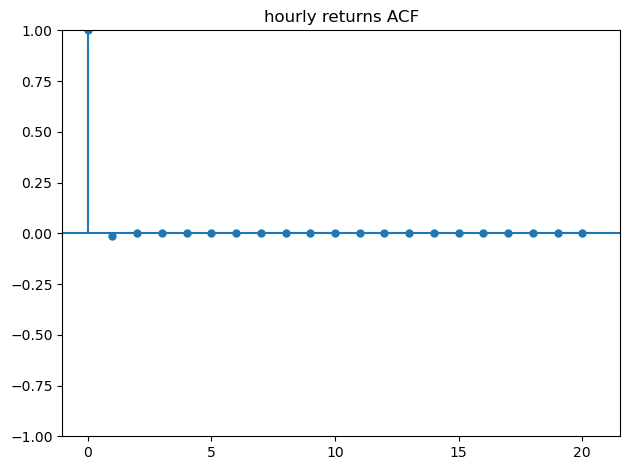

<Figure size 600x300 with 0 Axes>

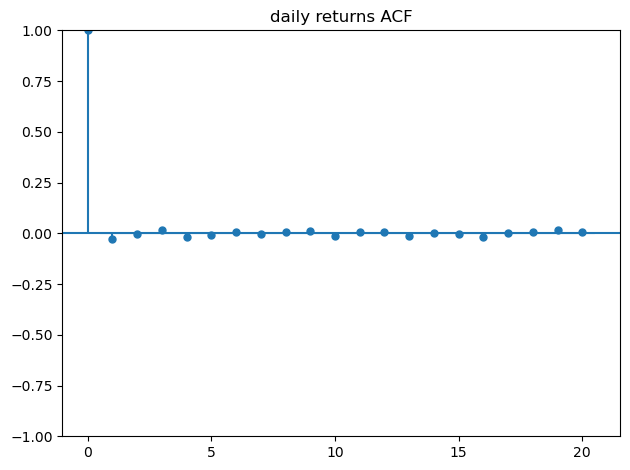

<Figure size 600x300 with 0 Axes>

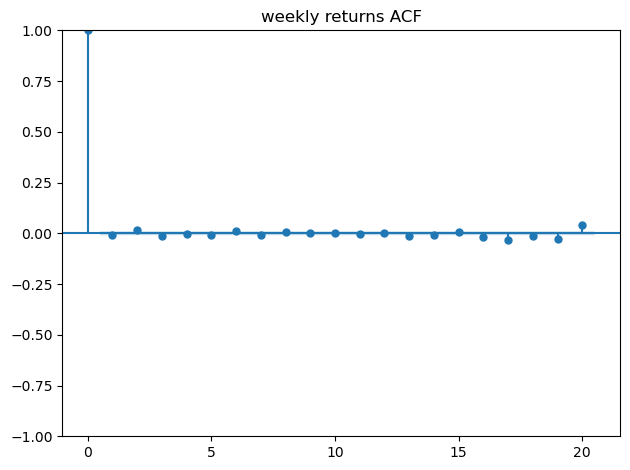

In [15]:
from pyspark.sql import functions as F
from functools import reduce


all_ret = (hourly
           .unionByName(daily)
           .unionByName(weekly)
           .filter(F.col("return_pct").isNotNull())
            .cache()
          )


all_ret.groupBy("period").count().show()


pdf = all_ret.toPandas()


print(pdf.groupby("period")["return_pct"].describe())

# autocollelation
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

for per in ["hourly","daily","weekly"]:
    vals = pdf.loc[pdf.period==per, "return_pct"].dropna()
    plt.figure(figsize=(6,3))
    plot_acf(vals, lags=20, title=f"{per} returns ACF")
    plt.tight_layout()


daily = pdf[pdf.period=="daily"].copy()

th = daily.return_pct.quantile(0.9)
daily["next_return"] = daily.groupby("ticker")["return_pct"].shift(-1)
signal = daily.return_pct > th

win_rate = (daily.loc[signal, "next_return"] < 0).mean()
print(f"Daily top-10% 異動後隔日反手空的win rate：{win_rate:.1%}")

### Using only 100 for checking outliers

In [16]:
avg_vol = (
    spark_df
      .groupBy("ticker")
      .agg(F.mean("volume").alias("avg_vol"))
)


top100 = (
    avg_vol
      .orderBy(F.desc("avg_vol"))
      .limit(100)
      .select("ticker")
)

# Only use top 100 to avoid outliers
top100_list = [r.ticker for r in top100.collect()]

filtered = spark_df.filter(F.col("ticker").isin(top100_list))


hourly_top100 = make_returns(filtered, "hour",  "hourly")
daily_top100  = make_returns(filtered, "day",   "daily")
weekly_top100 = make_returns(filtered, "week",  "weekly")

from functools import reduce
from pyspark.sql import DataFrame

all_ret_top100 = (
    hourly_top100.unionByName(daily_top100)
                   .unionByName(weekly_top100)
                   .filter(F.col("return_pct").isNotNull())
)

pdf_top100 = all_ret_top100.toPandas()
print(pdf_top100.groupby("period")["return_pct"].describe())

           count      mean        std        min       25%       50%  \
period                                                                 
daily    52754.0  0.098399   2.759648 -49.384405 -0.937354  0.028331   
hourly  695850.0  0.138256  19.082129 -98.540572 -0.203663  0.000000   
weekly   10362.0  0.463068   5.320697 -31.587189 -2.210651  0.240072   

             75%          max  
period                         
daily   1.054071    97.235403  
hourly  0.221110  6792.000000  
weekly  2.740236    62.349824  


In [17]:
# find outlier
extreme_thresh = 100  # 百分比，只要超过 ±100%
outliers = pdf[ pdf.return_pct.abs() > extreme_thresh ]
print("极端值样本（ticker, period, ts, return_pct）:")
print(outliers[["ticker","period","ts","return_pct"]])

极端值样本（ticker, period, ts, return_pct）:
        ticker  period                  ts  return_pct
1477156   GOLD  hourly 2024-06-03 14:00:00      6792.0


Detected outlier tickers: ['GOLD']

After dropping outliers, return_pct describe:
             count      mean       std        min       25%       50%  \
period                                                                 
daily    218123.0  0.075080  1.944165 -39.694336 -0.827739  0.060551   
hourly  2314921.0  0.007311  0.629344 -35.540102 -0.206186  0.000000   
weekly    44245.0  0.377735  4.246057 -42.498205 -1.838755  0.297915   

             75%        max  
period                       
daily   0.961074  63.648124  
hourly  0.225479  44.060886  
weekly  2.397434  79.063361  


<Figure size 600x300 with 0 Axes>

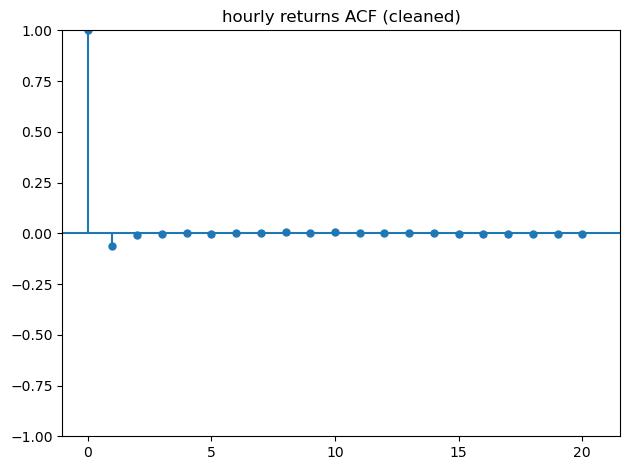

<Figure size 600x300 with 0 Axes>

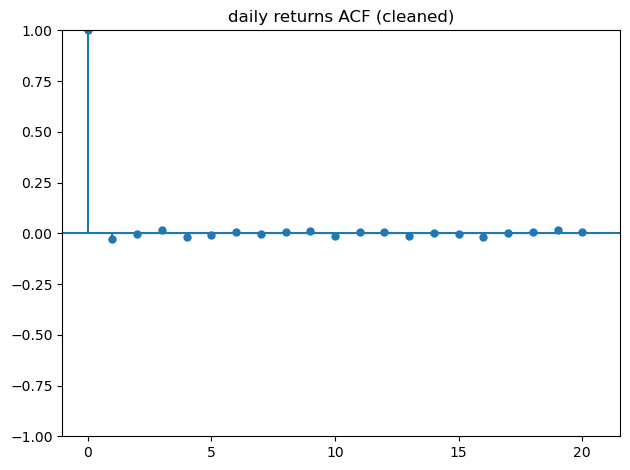

<Figure size 600x300 with 0 Axes>

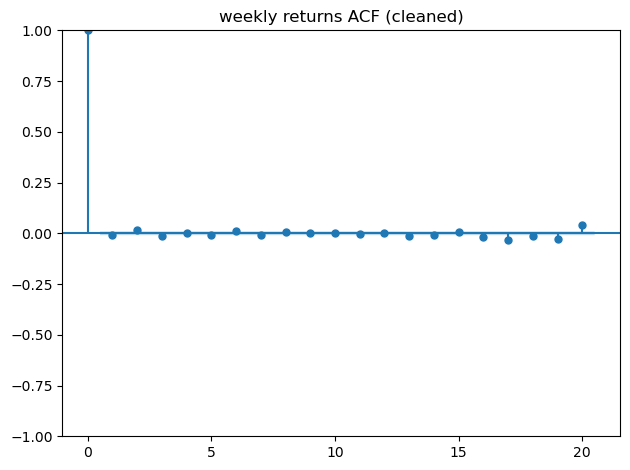

Daily top-10% cleaned win rate: 50.6%


In [18]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf


extreme_thresh = 100  # 阈值：±100%
outlier_tickers = pdf.loc[pdf.return_pct.abs() > extreme_thresh, 'ticker'].unique()
print("Detected outlier tickers:", outlier_tickers)

pdf_clean = pdf[~pdf.ticker.isin(outlier_tickers)].copy()


desc = pdf_clean.groupby('period')['return_pct'].describe()
print("\nAfter dropping outliers, return_pct describe:\n", desc)


for per in ['hourly', 'daily', 'weekly']:
    vals = pdf_clean.loc[pdf_clean.period == per, 'return_pct'].dropna()
    plt.figure(figsize=(6, 3))
    plot_acf(vals, lags=20, title=f"{per} returns ACF (cleaned)")
    plt.tight_layout()
    plt.show()


daily = pdf_clean[pdf_clean.period == "daily"].copy()
th = daily.return_pct.quantile(0.9)
daily["next_return"] = daily.groupby("ticker")["return_pct"].shift(-1)
signal = daily.return_pct > th
win_rate = (daily.loc[signal, "next_return"] < 0).mean()
print(f"Daily top-10% cleaned win rate: {win_rate:.1%}")

# LSTM model

In [14]:
df_aapl = df10[df10['ticker']=='AAPL'].sort_values('dt')

# get volume
data = df_aapl[['close','vol']].values


scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


# rolloing window, predict next close price
def create_sequences(data, seq_len=10):
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        
        y.append(data[i+seq_len, 0])
    return np.array(X), np.array(y)

SEQ_LEN = 20
X, y = create_sequences(data_scaled, SEQ_LEN)

# train/ test  80/20
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
model = Sequential([
    LSTM(32, input_shape=(SEQ_LEN, 2)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0325 - val_loss: 0.0017
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - val_loss: 0.0016
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - val_loss: 0.0015

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


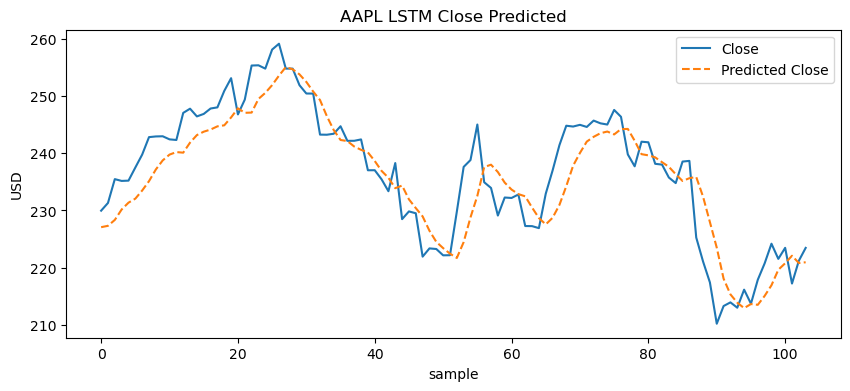

In [16]:
y_pred = model.predict(X_test)

dummy = np.zeros((len(y_pred), 2))
dummy[:,0] = y_pred.flatten()
inv_pred = scaler.inverse_transform(dummy)[:,0]

dummy[:,0] = y_test
inv_true = scaler.inverse_transform(dummy)[:,0]


plt.figure(figsize=(10,4))
plt.plot(inv_true, label='Close')
plt.plot(inv_pred, label='Predicted Close', linestyle='--')
plt.title("AAPL LSTM Close Predicted")
plt.xlabel("sample")
plt.ylabel("USD")
plt.legend()
plt.show();

In [17]:
mse   = mean_squared_error(inv_true, inv_pred)
rmse  = np.sqrt(mse)
mae   = mean_absolute_error(inv_true, inv_pred)
r2    = r2_score(inv_true, inv_pred)

print(f"MSE:   {mse:.4f}")
print(f"RMSE:  {rmse:.4f} USD")
print(f"MAE:   {mae:.4f} USD")
print(f"R²:    {r2:.4f}")

MSE:   26.5508
RMSE:  5.1527 USD
MAE:   4.1172 USD
R²:    0.7986
